# Welcome to the ODEs in Python Tutorial For Analog Computers and their Digital Computers!

First we're going to make sure everything we need is installed:

In a terminal window, run `py -m pip install (packagename))` for each of the packages below:

You can actually do this in the notebook by running !pip install package_name in a cell, if you make a new code cell below)

`pip install sympy`

`pip install numpy`

`pip install scipy`

`pip install matplotlib` (for plotting data)

`pip install nbconvert` (so you can see LaTeX in Jupyter Notebooks)

`pip install ppsim` (if you want to use population protocols)

### Let's make sure that went how we hope it went:

In [2]:
from sympy import *
from numpy import *
import scipy.integrate as intg
import ppsim


# Chemical Reaction Networks

<video width="600" height="300" 
       src="CRN.mp4"  
       controls>
</video>

You can read about Chemical Reaction Networks here: https://en.wikipedia.org/wiki/Chemical_reaction_network_theory

We can think of these as _massively distributed_ computing systems. Or, we can think of them as vats of chemicals where molecules bump into each other and react to form new chemicals. It's useful to concieve of these reactions as happening *all the time* - continuously. So we'll see that these chemical systems described (or are described by) systems of equations representing how the concentrations of the chemical species are changing over time.

#### Part 1: Converting a CRN to an ODE system

##### Consider the following CRN:

$$N: S = \{A, B, C\}, R = \{\rho_1, \rho_2, \rho_3\},$$ 

where $S$ is a set of molecular species involved and $R$ is a set of reactions that each consume and produce some of, those species:

 $$\rho_1 := A + 2B \rightarrow A + C$$
 $$\rho_2 := B + C + A \rightarrow 2A$$
 $$\rho_3 := B \rightarrow B + C$$ 

 There is plenty of lingo and jargon to learn about this, and we can pick that up with time. For now, let's just mention that for any of these reactions to take place, all the <b>reactants</b> (the molecules left of the $\rightarrow$ must be present at the same time).

 There are different <b>semantics</b> to this model (if you're a computer scientist), or kinetics (if you're a chemist). By that we mean that the stuff we just wrote above can be interpreted as having two very different meanings. One way of understanding these reactions is that there is some <b> probability </b> that one A and two B (we call these the <b>reactants</b>) all bump into each other at the same-ish time and place, in which case the reaction goes off and the <b> products </b> (to the right of $\rightarrow$) are generated. This way of understanding it is called the <b> stochastic model of chemical kinetics </b> and it requires thinking about probability. It is harder to use than our other option, the <b> mass-action </b> model. In this model - odd as the intuition may be - we don't try to deal with individual molecules at all. Instead, we assume we assume that there is _a lot_ of each species available, and we think about how the _relative quantites_ of each species changes over time. Thus, we are interested in the _concentration_ of each species. In doing so, geometry disappears from the problem: there is no longer a "place" where a reaction happens - all of these reactions that are _enabled_ by the presence of their respective reactants are _always_ going off, but with different rates and different products. We will focus on modeling CRNs using this mass-action, or _deterministic_, semantics.

How can we convert this into a system of ordinary differential equations representing the mass-action kinetics of a system governed by these reaction rules?

First we obtain some values $\Delta_i^s$ for each reaction $\rho_i$ and species $s$, representing the net change of $s$ in $\rho_i$. For example, $\Delta_1^a = 0$ since $A$ (though appearing as a catalyst) is produced and consumed in the same quantity. Likewise, $\Delta_1^b = -2$ and $\Delta_3^c = 1$.

### ////////////////////////\\\\\\\\\\\\\\\\\\\\\\\\\
#### <b> Pause here and write down all the $\Delta$ values. </b>
### \\\\\\\\\\\\\\\\\\\\\\\\/////////////////////////

Next we get the rate of each reaction: $rate_i(t) = k_i \prod_{j=1}^n x_j^{a_{ij}}$ where $k_i$ is the rate constant (these are normally written above the $\rightarrow$. We don't have any of these above, so we assume them to be equal to 1), $x_j$ is the concentration of the $j$-th reactant, and $a_{ij}$ is the coefficient of the $j$-th reactant in the $i$-th reaction. 

For example, $$rate_1(t) = a(t)b(t)^2$$

### ////////////////////////\\\\\\\\\\\\\\\\\\\\\\\\\
#### <b> Pause here and write down all the reaction rates. </b>
### \\\\\\\\\\\\\\\\\\\\\\\\/////////////////////////

##### Type check: _reactions_ have rates of reaction. _species_ have rates of change.

Ultimately, we want equations represention the rate of change of each species - $\frac{dy}{dt}$ for each $y \in S$.

To get the rate of change of species $A$, we sum over all reactions $r \in R$ the values $\Delta_r^a * rate_r$.

That is, $$a'(t) = \sum_{r \in R} \Delta_r^a * rate_r $$ and, in particular, we have $$a'(t) = b(t)c(t)a(t),$$ $$b'(t) = -2a(t)b(t)^2 -b(t)c(t)a(t)$$ $$c'(t) = \text{ your turn!}$$

Note: This gives us a function of $t$, like we'd expect: the rate of change of some species is itself a function of time, and its integral is of course the actual "amount" or concentration of that species at time $t$.

#### Note: It gets old writing (t) next to everything. We can just say $$b' = 2ab^2 - bca,$$ knowing that everything involved is a function of time. 

All ODE systems corresponding to chemical reaction networks have the following properties (we might find that this is not an exhaustive list of their specific properties...): They are

- <b>Autonomous</b> There are no terms in the right-hand side equations where $t$ appears independetly. e.g. $x'(t) = a(t)^2 + t is$ not possible.
- <b>First-order</b> There are no equations like $y'' = ...$. Rather, we see only the solution values (like $a(t)$) and their derivatives $a'(t)$.
- <b>Polynomial</b> If we treat the species concentrations as variables, then the right-hand side of every ODE equation is a polynomial of these variables.

Thus, they make up a fairly specific class of differential equations - this is good to know for when we attempt to solve or manipulate them.

### Part 2: Modeling ODE systems in Python

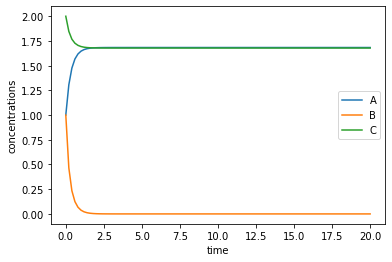

In [4]:
#solve an ordinary differential equation derived from a CRN and plot the solution
import numpy as np
import scipy.integrate as intg
import matplotlib.pyplot as plt

def g(t,y):
    A = y[0]
    B = y[1]
    C = y[2]

    dA_dt = B*C*A
    dB_dt = -2*A*B**2 - B*C*A
    dC_dt = B*C - B*C*A - A*B**2

    return np.array([dA_dt,dB_dt,dC_dt])

t_span = np.array([0,20])
times = np.linspace(t_span[0],t_span[1],101)

y0 = np.array([1,1,2]) # Initial values for the system variables

soln = intg.solve_ivp(g,t_span,y0,t_eval=times)

t = soln.t
A = soln.y[0]
B = soln.y[1]
C = soln.y[2]

plt.figure()
plt.plot(t,A, '-',label='A')
plt.plot(t,B, '-',label='B')
plt.plot(t,C, '-',label='C')
plt.xlabel("time")
plt.ylabel("concentrations")
plt.legend()
plt.show()


#### Let's look at another example plot. This time we don't know the CRN it corresponds to:

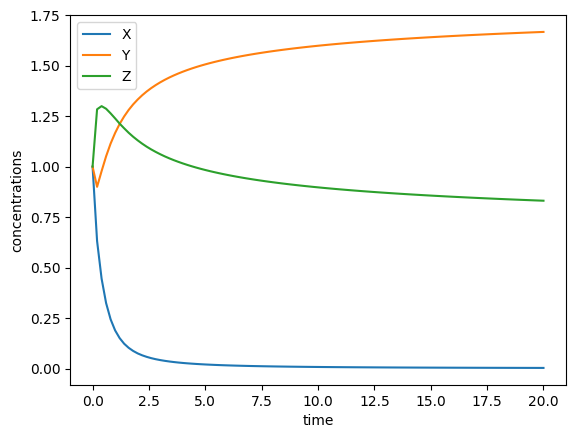

In [12]:
#solve an ordinary differential equation derived from a CRN and plot the solution
import numpy as np
import scipy.integrate as intg
import matplotlib.pyplot as plt

def f(t,y):
    X = y[0]
    Y = y[1]
    Z = y[2]

    dX_dt = -4*(X**2)*(Y**3)
    dY_dt = -6*(X**2)*(Y**3) + 2*X*Z**2
    dZ_dt = 8*(X**2)*(Y**3) -2*X*Z**2

    return np.array([dX_dt,dY_dt,dZ_dt])

t_span = np.array([0,20])
times = np.linspace(t_span[0],t_span[1],101)

y0 = np.array([1,1,1])

soln = intg.solve_ivp(f,t_span,y0,t_eval=times)

t = soln.t
X = soln.y[0]
Y = soln.y[1]
Z = soln.y[2]

plt.figure()
plt.plot(t,X, '-',label='X')
plt.plot(t,Y, '-',label='Y')
plt.plot(t,Z, '-',label='Z')
plt.xlabel("time")
plt.ylabel("concentrations")
plt.legend()
plt.show()


#### Challenge Activity: Are you able to work backwards to figure out the/a CRN from which this ODE system is derived?

###### Do the dynamics suggested by the plot give you any clue as to the "shape" of the reactions involved?

###### There is a technique to this - but it is not as direct as converting a CRN to an ODE system.

# Part 3: General-purpose analog computers (GPACs)

GPACs are a model we see pretty often in our seminar. They can be thought of as the class of circuits you can construct by (responsibly) chaining together the following modules:

Addition: x(t), y(t) go int, x(t) + y(t) comes out.

Multiplicaton: ...

Integration: x(t), t go in, $\int_0^t x(t)dt$ comes out

Constant: Some continual stream of a static value like 1, $\pi$, $\frac{3}{4}$, etc.

Here is a visual depiction of these modules, from (Bournez, Graca, Pouly - <i>On the Functions Generated by the General Purpose Analog Computer</i>):

<p align="center">
<img src="gpacfns.JPG" width="400" height="200">
</p>


If we play around with these modules enough, we discover that a general purpose analog computer is any ODE system that looks like this:

$$y'(t) = p (y,t)$$
$$y'(0) = y_0$$

for some polynomial $p$. This can be called a PIVP, or <i> polynomial initial value problem </i>.

Note: Here, $y$ is a vector so it actually contains all the individual solutions we were dealing with earlier. I.e. y = [a, b, c]. Likewise, $y_0$ is some particular initial value vector that assigns an initial value to each of the components in $y$.

GPACs are a very important and useful tool. The GPAC model originally comes from Vannevar Bush's differential analyzer. Shannon developed theoretical model of this device. It has since been modified and updated by a number of mathematicians including Pour El and, more recently, Bournez, Campagnolo, Graca, and Pouly.

<p align="center">
<img src="diffanalyzer.jpg" width="400" height="250">
</p>

We've got something similar to a differential analyzer here at Drake, though miniaturized:

<p align="center">
<img src="that.jpg" width="300" height="400">
</p>

This nice little device is basically a field-programmable analog circuit which can be plugged into an oscilliscope that lets us view the solutions as voltages!

### We need to take a detour and learn a trick!

One way we could discuss the relative power of each model is by showing that we can convert between them. Can we convert freely between GPACs and CRNs?

We know one direction is possible: because <b> every CRN converts to a system of ODEs that has this GPAC form. </b>

Is this true the other way around? Can every GPAC be converted to a CRN?




#### ////////////////////////////\\\\\\\\\\\\\\\\\\\\\\\\\\
### Challenge Activity: Pause here and give an example of a GPAC that isn't convertible to a CRN, or prove that every GPAC is a CRN.
#### \\\\\\\\\\\\\\\\\\\\\\\\\\\\//////////////////////////

Indeed, GPACs are not _by nature_ CRN-implementable.

Earlier we mentioned some properties of CRN ODEs: they are autonomous, polynomial, and first-order. We suggested that some other features may be left out. One important feature is that ODEs of CRNs have the following form: $$ x' = p_x - q_x * x $$ where $p_x$ and $q_x$ are <b> positive polynomials </b>. $p$ and $q$ are positive in the sense that the coefficient in front of them is a positive number. They are polynomials in that they are made up of monomials that multiply various powers of the system's variables $x, y, z,...$. Note: the rule does _not_ preclude the presence of $x$ in $p_x$ or $q_x$.

If you want to, you can think of this instead as $$x' = p_x + q_x * x$$ where all terms in $q_x$ are negative and all terms in $p_x$ are positive. Whichever you like.

The key point here is that any term of $x'$ that has a negative coefficient must include $x$. This goes for every variable $x$ in the system, of course. It is easy to construct GPACs for which this is not the case. 

Consider the system $$ G: $$  $$x' = x - y$$ $$y' = y^2 + yx$$

### Activity: 

1. As practice, write the code to simulate the ODE system.
2. Try to write a reaction system for it. What issue do you run into?

In [ ]:
#solve an ordinary differential equation derived from a CRN and plot the solution
import numpy as np
import scipy.integrate as intg
import matplotlib.pyplot as plt

def f(t,y):
    X = y[0]
    Y = y[1]

    dX_dt = 
    dY_dt = 

    return np.array()

t_span = np.array([0,20])
times = np.linspace(t_span[0],t_span[1],101)

y0 = np.array([1,1])

soln = intg.solve_ivp(f,t_span,y0,t_eval=times)

t = soln.t
X = soln.y[0]
Y = soln.y[1]

plt.figure()
plt.plot(t,X, '-',label='X')
plt.plot(t,Y, '-',label='Y')
plt.xlabel("time")
plt.ylabel("concentrations")
plt.legend()
plt.show()


### This is not the end of the story! 
#### We can convert any GPAC system into a CRN using a technique called _dual railing_

A good place to read about this is around p.34 of <a href = "https://dr.lib.iastate.edu/server/api/core/bitstreams/37ca751a-f211-46ff-b1e2-1ffe10c69a25/content">Xiang Huang's thesis</a>.

### Pause for Sanity:

We are now talking about "converting" things into other things. Any conversion requires some explanation and an account of which things we hope remain true, and which ones we hope become true, during and after the transformation. After all, I can convert any ODE system into the flat-line ODE system by setting the rates of all variables to 0. But that deletes most of the interesting properties I may have had before. So what kind of conversion are we talking about here?

Normally we are talking about converting a system to one that is equivalent in some sense. There are many things "equivalent" can mean. One family of meanings are those in which the long-term behavior of the system is the same. In the dual-railing technique discussed below, our goal is to <i>preserve</i> the limiting behavior of certain variables, i.e. $$\lim_{t \rightarrow \infty} x(t) = \lim_{t \rightarrow \infty} \hat{x}(t)$$

Also, before we go any further - it's time to be good programmers and encapsulate our solving-and-plotting procedure:

In [3]:
import numpy as np
import scipy.integrate as intg
import matplotlib.pyplot as plt

def solve_and_plot_ode(ode_func, initial_values, time_span, num_points=101):
    times = np.linspace(time_span[0], time_span[1], num_points)
    soln = intg.solve_ivp(ode_func, time_span, initial_values, t_eval=times)
    
    
    plt.figure()
    for i in range(soln.y.shape[0]):
        plt.plot(soln.t, soln.y[i], '-', label=f'Variable {i+1}')
    
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Solution of the ODE System")
    plt.legend()
    plt.show()



Also - if you want to, you can use the following function to turn any dictionary ODE system into the kind of function we've been passing to solve_ivp. This might save you some small amount of time:

In [1]:
from sympy import sympify

def functionize_sympy_dict(system):
    spfy = sympify(system) #actually a little dangerous. sympify calls eval(). but whatever
    def sys_rhs(t, y):
    # Create a dictionary mapping variable names to their current values
        var_values = {var: value for var, value in zip(spfy.keys(), y)}

        # Evaluate each expression in the system
        dxdts = [expression.evalf(subs=var_values) for expression in spfy.values()]
        return dxdts
    

    return sys_rhs



In [ ]:
my_sys = {'x': "2*x + 3*y", 'y': "-x + 4*y - z", 'z': "x - 2*y + 3*z"}
my_fun = functionize_sympy_dict(my_sys)
#...

# Technique 1: The dual-rail method

We do the following for every variable $y_i$ in the system: the trick is to re-write each variable of the ODE system as two variables: So, for $y_i$ we construct $u_{i}$ and $v_{i}$, so that (with the goal of) $y_i = u_i - v_i$. We'll have to give these new variables their own ODEs later, in such a way that this equation to $y_i$ is true. For now, just know what we're shooting for is to use them to represent an old variable that doesn't have the CRN-implementable format we described earlier.

Since we start with a GPAC, there's some polynomial $p_i$ that describes its variable $y_i$ as $y_i' = p_i(y_1,y_2,...,y_n)$.

We can represent $p_i$ as $p_i = p_i^+ - p_i^-$ where both are positive polynomials. Emphasis on _represent_ : we are not _changing_ anything about that polynomial, just re-writing it to have this shape. Note that $p_i^-$ is not written as a product with $y_i$ - that's the reason we can't outright say it's in CRN format.

Now define the new ODEs to be: $$ u_i' = p_i^+ - u_iv_i(p_i^+ + p_i^-), \text{ and}$$ $$ v_i' = p_i^- - u_iv_i(p_i^+ + p_i^-).$$

Plus, we add a new variable $z' = 1 - (u_1 - v_1)*z$.

Here is the punchline: $$y_i' = u_i' - v_i' = p^+_i - p_i^- = p_i,$$ which is the original polynomial expression but now written (using new variables) in CRN-implementable form.

### Activity: 

Try this method on $$ G: $$  $$x' = x - y$$ $$y' = y^2 + yx$$

# Technique 2: Zero initial values

#### Let's look at another important technique, which allows us to take an arbitrary GPAC (or CRN) and transform it into an equivalent one, but whose initial values are all 0.

You may be wondering: why is it possible to have zero initial values at all? 

### An aside: analyticity
All PIVP solutions have an important property known as <i> analyticity </i> - that is, they are analytic functions. Analytic functions are important in many ways, but for us it suffices to know that they must be <i>smooth</i>: not only continuous everywhere, but differentiable everywhere. This makes some sense, since we don't expect either quantities nor their rates of change to jump sharply, but smoothly. If the rate of change of $x$ goes from 1 to 2, it does not do this in an instant, but as a result of continuous changes in its conditions of development (other variables changing continuously).

Because of analyticity, it is not possible for a CRN system variable that is non-zero to become zero. If it did, it would "crash" to a flat line and introduce a sharp (non-smooth) change in its rate of change. If $x(t) = 0$, then either $x(t) = 0$ for all times $t \in [0,\infty)$ or one other possibility maybe the case:

$x(0) = 0$. It is not a violation of smoothness for $x$ to become positive after $t=0$, in the same way that it is a violation of smoothness for it to crash to $0$ later. One way to think of this is that, since "time starts at 0", we just need to be ``half-continuous" on the right.

Try out the system below:



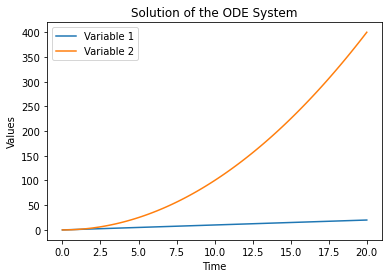

In [7]:
def zero_example(t, y):
    X = y[0]
    Y = y[1]
    dX_dt = 1
    dY_dt = 2*X
    return [dX_dt, dY_dt]

y0 = [0, 0]
t_span = (0, 20)

solve_and_plot_ode(zero_example, y0, t_span)

### Activity: 

The one-variable system below is CRN-implementable. Write down an implementation that uses two reactions. 

Two hints: 1. use rate constants wisely 2. reactions like $\emptyset \rightarrow A$ are allowed (despite what the reality of chemistry and physics has to say about it), where $\emptyset$ means "no reactants are involved". Note that such a reaction must happen at some constant rate, since none of the species concentrations affect it.

What does your choice of rate constants have to do with the value this ODE solution seems to converge to?

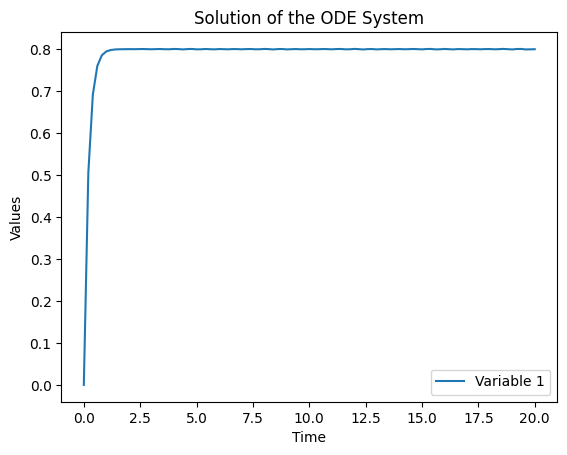

In [4]:
def compute_four_fifths(t, y):
    X = y[0]
    dX_dt = -5*X + 4
    return [dX_dt]

y0 = [0]
t_span = (0, 20)

solve_and_plot_ode(compute_four_fifths, y0, t_span)

Why do we allow reactions that so obviously violate the conservation of mass? Because - and you may have guessed it - we can always rewrite such reactions as a "physically reasonable" set of reactions with equivalent behavior. 